In [102]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import FinanceDataReader as fdr
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [105]:
def preprocess_(path,  column_, slice='',  encoding=None, header='infer'):

    df = pd.read_csv(path, encoding=encoding, header=header)
    
    if slice:
        df = df[slice]

    df.columns = column_

    if (type(df.iloc[:,1][1])==str):
        df.iloc[:,1] = df.iloc[:,1].apply(lambda x: float(x.replace(',', '')))
        
    df['Date'] = df['Date'].str.replace('[^0-9]', '')
    df['Date'] = df['Date'].apply(lambda x: x[:4]+'-'+x[4:6]+'-'+x[6:])
    df['Date'] = pd.to_datetime(df['Date'])

    df.sort_values('Date', inplace=True)
    df.reset_index(inplace=True)
    df.drop(['index'], axis=1, inplace=True)

    return df

In [106]:
ks = preprocess_(path="../datasets/KS200.csv", slice=['Date', 'Close'], column_=['Date', 'KS200'])
er = preprocess_(path="./er.csv", column_=['Date', 'ER'], encoding='CP949')
wti = preprocess_(path="./wti.csv", slice=['날짜', '종가'], column_=['Date', 'WTI'])
nickel = preprocess_(path="./nickel.csv", slice=['날짜', '종가'], column_=['Date', 'Nickel'])
copper = preprocess_(path="./copper.csv", slice=['날짜', '종가'], column_=['Date', 'Copper'])
nasdaq = preprocess_(path="./NASDAQ.csv", slice=['날짜', '종가'], column_=['Date', 'Nasdaq'])

C:\Users\dbswo\AppData\Local\Temp\ipykernel_3852\2556062775.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Date'] = df['Date'].str.replace('[^0-9]', '')
C:\Users\dbswo\AppData\Local\Temp\ipykernel_3852\2556062775.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Date'] = df['Date'].str.replace('[^0-9]', '')
C:\Users\dbswo\AppData\Local\Temp\ipykernel_3852\2556062775.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Date'] = df['Date'].str.replace('[^0-9]', '')
C:\Users\dbswo\AppData\Local\Temp\ipykernel_3852\2556062775.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Date'] = df['Date'].str.replace('[^0-9]', '')
C:\Users\dbswo\AppData\Local\Temp\ipykernel_3852\2556062775.py:13: FutureWarning: The default value of regex will change from True to False in a fut

In [107]:
import datetime
from functools import reduce
dfs = [er, wti, nickel, copper, nasdaq]
union = reduce(lambda left, right: pd.merge(left, right, on='Date', how='inner'),dfs)
union['Date'] = union['Date'].apply(lambda x: x+datetime.timedelta(days=1))
union

,Date,ER,WTI,Nickel,Copper,Nasdaq
0,2020-05-05,1226.0,20.39,11812.0,2.3995,8710.72
1,2020-05-07,1224.5,23.99,12303.0,2.4420,8854.39
2,2020-05-08,1225.5,23.55,12330.0,2.4700,8979.66
3,2020-05-12,1223.0,24.14,12354.0,2.4710,9192.34
4,2020-05-13,1225.0,25.78,12324.0,2.4515,9002.55
...,...,...,...,...,...,...
444,2022-03-26,1221.0,113.90,35491.0,4.6985,14169.30
445,2022-03-29,1225.0,105.96,32725.0,4.7255,14354.90
446,2022-03-30,1211.0,104.24,31803.0,4.7330,14619.64
447,2022-03-31,1210.5,107.82,32893.0,4.7545,14442.28


In [28]:
ks

,Date,KS200
0,2020-05-04,250.60
1,2020-05-06,255.00
2,2020-05-07,254.46
3,2020-05-08,256.62
4,2020-05-11,254.95
...,...,...
468,2022-03-25,362.06
469,2022-03-28,362.06
470,2022-03-29,363.77
471,2022-03-30,364.50


In [108]:
union = pd.merge(union, ks, how='inner', on='Date')
union

,Date,ER,WTI,Nickel,Copper,Nasdaq,KS200
0,2020-05-07,1224.5,23.99,12303.0,2.4420,8854.39,254.46
1,2020-05-08,1225.5,23.55,12330.0,2.4700,8979.66,256.62
2,2020-05-12,1223.0,24.14,12354.0,2.4710,9192.34,253.37
3,2020-05-13,1225.0,25.78,12324.0,2.4515,9002.55,255.85
4,2020-05-14,1225.0,25.29,12254.0,2.4360,8863.17,253.65
...,...,...,...,...,...,...,...
342,2022-03-24,1218.5,114.93,32380.0,4.7765,13922.60,363.38
343,2022-03-25,1222.0,112.34,37049.5,4.7430,14191.84,362.06
344,2022-03-29,1225.0,105.96,32725.0,4.7255,14354.90,363.77
345,2022-03-30,1211.0,104.24,31803.0,4.7330,14619.64,364.50


In [109]:
from sklearn.preprocessing import StandardScaler

data = union.drop(['Date', 'KS200', 'ER', 'WTI'], axis=1)
target = union['KS200']

len_ = round(len(data)*0.8)
x_train, x_test = data[:len_], data[len_:]
y_train, y_test = target[:len_], target[len_:]

lr = LinearRegression()
lr.fit(x_train, y_train)
pred = lr.predict(x_test)

mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)
print(f'input_data with none\ntarget with none \nmse : {mse} \nrmse : {rmse} \nr2 : {r2}')

input_data with none
target with none 
mse : 2953.6575855532965 
rmse : 54.347562829930986 
r2 : -11.582713283698256


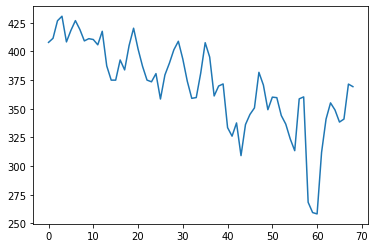

In [19]:
plt.plot(pred)

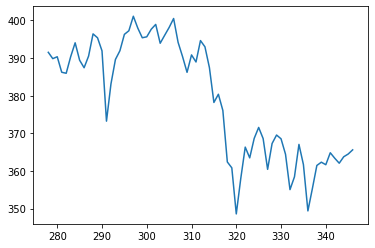

In [20]:
plt.plot(y_test)

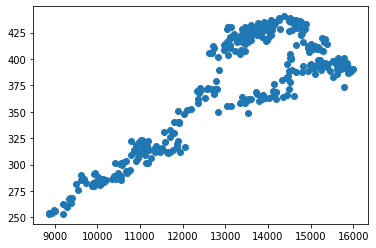

In [34]:
plt.scatter(data['Nasdaq'], target)

In [111]:
from sklearn.preprocessing import StandardScaler

data = union.drop(['Date', 'KS200', 'WTI', 'ER'], axis=1)
# data['ER'] = (data['ER'] / 1224.5) * 100
# data['WTI'] = (data['WTI'] / 23.99) * 100
# data['Nickel'] = (data['Nickel'] / 12303.0) * 100
# data['Copper'] = (data['Copper'] / 2.442) * 100
# data['Nasdaq'] = (data['Nasdaq'] / 8854.39) * 100
target = (union['KS200'] / 254.46) * 100

data = np.log1p(data)
data = data.diff(1)
data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(['index'], axis=1, inplace=True)

target = target[1:]
target = pd.DataFrame(target)
target.reset_index(inplace=True)
target.drop(['index'], axis=1, inplace=True)

len_ = round(len(data)*0.8)
x_train, x_test = data[:len_], data[len_:]
y_train, y_test = target[:len_], target[len_:]

lr = LinearRegression()
lr.fit(x_train, y_train)
pred = lr.predict(x_test)

mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)
print(f'input_data with none\ntarget with none \nmse : {mse} \nrmse : {rmse} \nr2 : {r2}')

input_data with none
target with none 
mse : 60.5645175447898 
rmse : 7.782320832810082 
r2 : -0.6705960943676188


In [113]:
from sklearn.preprocessing import StandardScaler

data = union.drop(['Date', 'KS200', 'WTI', 'ER'], axis=1)
#data['ER'] = (data['ER'] / 1224.5) * 100
#data['WTI'] = (data['WTI'] / 23.99) * 100
data['Nickel'] = (data['Nickel'] / 12303.0) * 100
data['Copper'] = (data['Copper'] / 2.442) * 100
data['Nasdaq'] = (data['Nasdaq'] / 8854.39) * 100
target = (union['KS200'] / 254.46) * 100

data = np.log1p(data)
data = data.diff(1)
data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(['index'], axis=1, inplace=True)

target = target[1:]
target = pd.DataFrame(target)
target.reset_index(inplace=True)
target.drop(['index'], axis=1, inplace=True)

len_ = round(len(data)*0.8)
x_train, x_test = data[:len_], data[len_:]
y_train, y_test = target[:len_], target[len_:]

lr = LinearRegression()
lr.fit(x_train, y_train)
pred = lr.predict(x_test)

mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)
print(f'input_data with none\ntarget with none \nmse : {mse} \nrmse : {rmse} \nr2 : {r2}')

input_data with none
target with none 
mse : 66.23261647648026 
rmse : 8.138342366629722 
r2 : -0.8269434792992103


In [71]:
union[union["Date"]=='2020-05-07']

,Date,ER,WTI,Nickel,Copper,Nasdaq,KS200
0,2020-05-07,1224.5,23.99,12303.0,2.442,8854.39,254.46


<AxesSubplot:>

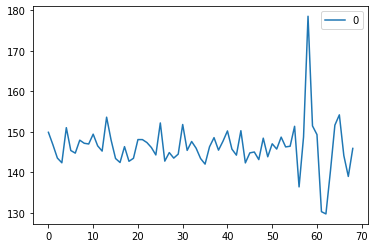

In [81]:
pd.DataFrame(pred).plot()

<AxesSubplot:>

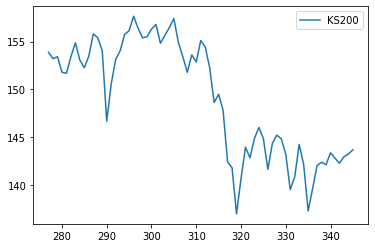

In [82]:
y_test.plot()

In [83]:
corr = union.corr
corr

<bound method DataFrame.corr of           Date      ER     WTI   Nickel  Copper    Nasdaq   KS200
0   2020-05-07  1224.5   23.99  12303.0  2.4420   8854.39  254.46
1   2020-05-08  1225.5   23.55  12330.0  2.4700   8979.66  256.62
2   2020-05-12  1223.0   24.14  12354.0  2.4710   9192.34  253.37
3   2020-05-13  1225.0   25.78  12324.0  2.4515   9002.55  255.85
4   2020-05-14  1225.0   25.29  12254.0  2.4360   8863.17  253.65
..         ...     ...     ...      ...     ...       ...     ...
342 2022-03-24  1218.5  114.93  32380.0  4.7765  13922.60  363.38
343 2022-03-25  1222.0  112.34  37049.5  4.7430  14191.84  362.06
344 2022-03-29  1225.0  105.96  32725.0  4.7255  14354.90  363.77
345 2022-03-30  1211.0  104.24  31803.0  4.7330  14619.64  364.50
346 2022-03-31  1210.5  107.82  32893.0  4.7545  14442.28  365.61

[347 rows x 7 columns]>

<AxesSubplot:>

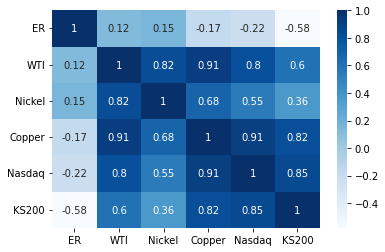

In [84]:
import seaborn as sns
union_withoutDate = union.drop(['Date'], axis=1)
corr_before = union_withoutDate.corr(method='pearson')
sns.heatmap(corr_before,annot=True, cmap='Blues')

In [86]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
model = ols('KS200 ~ ER + Nickel + Copper + Nasdaq', union)

pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(model.exog, i)} 
             for i, column in enumerate(model.exog_names)
             if column != 'Intercept')

,컬럼,VIF
0,ER,1.204705
1,Nickel,2.269981
2,Copper,7.958339
3,Nasdaq,5.931109


In [95]:
a = model.fit()
a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  KS200   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     856.0
Date:                Tue, 26 Apr 2022   Prob (F-statistic):          1.09e-176
Time:                        14:47:27   Log-Likelihood:                -1456.1
No. Observations:                 347   AIC:                             2922.
Df Residuals:                     342   BIC:                             2942.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    720.4804     29.938     24.066      0.000     661.595     779.366
ER            -0.5298      0.024    -21.902      0.000      -0.577      -0.482
Nickel        -0.0014      0.000     -5.027      0.000      -0.002      -0.001
Copper        38.0372      3.617     10.517      0.000      30.923      45.151
Nasdaq         0.0112      0.001      9.830      0.000       0.009       0.013
==============================================================================
Omnibus:                       18.431   Durbin-Watson:                   0.150
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.005
Skew:                          -0.093   Prob(JB):                       0.0183
Kurtosis:                       2.280   Cond. No.                     7.82e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.82e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""